# Import Libraries

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import label_binarize, PolynomialFeatures
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_curve, auc, mean_squared_error, roc_auc_score, mean_absolute_error, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE


# Data Processing

In [11]:
train_df = pd.read_csv("../../data/train_data_v3.csv")
validate_df = pd.read_csv("../../data/validate_data_v3.csv")
test_df = pd.read_csv("../../data/test_data_v3.csv")

In [12]:
print(train_df.shape)
print(validate_df.shape)
print(test_df.shape)

(8000, 70)
(1000, 70)
(1000, 70)


# Evaluation Function

In [13]:
def evaluate(y_pred, y_test, X_test, model):
    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Compute and display confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", conf_matrix)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

    # Accuracy1: Exact match (diagonal of confusion matrix)
    acc1 = np.mean(y_pred == y_test)
    print("Accuracy1 (Exact match):", acc1)

    # Accuracy2: One-off accuracy (prediction is within ±1 of true label)
    one_off = np.abs(y_pred - y_test) <= 1
    acc2 = np.mean(one_off)
    print("Accuracy2 (One-off accuracy):", acc2)


    # Compute AUC-ROC curve
    y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])
    y_pred_prob = model.predict_proba(X_test)
    n_classes = y_test_bin.shape[1]

    plt.figure()
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {auc(fpr, tpr):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc='best')
    plt.show()

# Feature Importance Function

In [14]:
def plot_top_feature_importances(model, X, selector=None, top_n=10):
    """
    Plots the top N feature importances from a trained model.
    
    Parameters:
    - model: Trained sklearn model with feature_importances_ attribute
    - X: Original (full) training feature DataFrame
    - selector: RFE selector used to reduce features (optional)
    - top_n: Number of top features to display
    """
    if selector is not None:
        # Filter features using RFE support mask
        feature_names = X.columns[selector.support_]
    else:
        feature_names = X.columns

    # Create a DataFrame with importances and feature names
    importances = model.feature_importances_
    feat_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(feat_importance_df['Feature'], feat_importance_df['Importance'], color='skyblue')
    plt.xlabel("Feature Importance Score")
    plt.ylabel(f"Top {top_n} Features")
    plt.title(f"Top {top_n} Feature Importances")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


# Define Features & Target

In [15]:
# Define features and target
X_train = train_df.drop(columns=["Severity"])
y_train = train_df["Severity"]

X_validate = validate_df.drop(columns=["Severity"])
y_validate = validate_df["Severity"]

X_test = test_df.drop(columns=["Severity"])
y_test = test_df["Severity"]


# Baseline Model

In [16]:
y_train_adjusted = y_train - np.min(y_train)

# Train the Random Forest model
model = XGBClassifier(random_state=42, eval_metric='mlogloss')
model.fit(X_train, y_train_adjusted)

# Make predictions
y_pred = model.predict(X_validate)
y_pred_original = y_pred + np.min(y_train)


In [17]:
y_pred_original

array([2, 2, 4, 3, 4, 2, 2, 4, 2, 4, 1, 2, 2, 4, 4, 1, 4, 3, 2, 2, 2, 3,
       2, 2, 2, 4, 4, 2, 4, 1, 3, 2, 2, 4, 4, 2, 2, 2, 2, 2, 4, 3, 1, 1,
       4, 3, 4, 2, 2, 4, 4, 2, 2, 2, 2, 2, 3, 1, 4, 2, 3, 4, 3, 1, 2, 2,
       2, 3, 2, 2, 4, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 3, 3, 2, 2, 2, 2, 3,
       2, 2, 2, 4, 2, 3, 3, 2, 1, 2, 4, 4, 2, 3, 2, 1, 3, 4, 4, 2, 2, 3,
       2, 3, 2, 2, 1, 1, 3, 1, 2, 2, 3, 3, 4, 2, 4, 3, 2, 2, 4, 2, 3, 2,
       1, 4, 2, 2, 4, 4, 2, 3, 4, 3, 4, 3, 4, 3, 4, 4, 2, 3, 3, 2, 2, 4,
       2, 2, 2, 3, 2, 2, 4, 1, 4, 3, 3, 4, 4, 4, 2, 4, 3, 4, 3, 4, 4, 4,
       2, 1, 2, 1, 3, 2, 4, 2, 2, 2, 3, 2, 3, 4, 2, 2, 2, 2, 2, 2, 4, 2,
       3, 4, 4, 2, 2, 2, 4, 2, 2, 4, 4, 2, 4, 2, 2, 1, 4, 1, 2, 3, 2, 2,
       3, 1, 2, 2, 2, 3, 4, 2, 4, 2, 2, 3, 3, 4, 3, 2, 2, 2, 4, 2, 2, 2,
       2, 2, 4, 4, 2, 4, 3, 2, 4, 3, 4, 3, 2, 3, 2, 2, 2, 1, 4, 4, 3, 2,
       2, 2, 2, 4, 3, 3, 3, 2, 2, 3, 3, 2, 1, 3, 2, 1, 3, 2, 3, 2, 2, 3,
       4, 2, 4, 2, 4, 2, 2, 3, 2, 3, 4, 4, 2, 2, 3,

Accuracy: 0.573
F1 Score: 0.6439429539045742
Classification Report:
               precision    recall  f1-score   support

           1       0.24      1.00      0.39        14
           2       0.97      0.53      0.69       828
           3       0.38      0.73      0.50       124
           4       0.11      0.76      0.19        34

    accuracy                           0.57      1000
   macro avg       0.42      0.76      0.44      1000
weighted avg       0.86      0.57      0.64      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 31 442 147 208]
 [ 12  10  91  11]
 [  1   3   4  26]]
Accuracy1 (Exact match): 0.573
Accuracy2 (One-off accuracy): 0.776


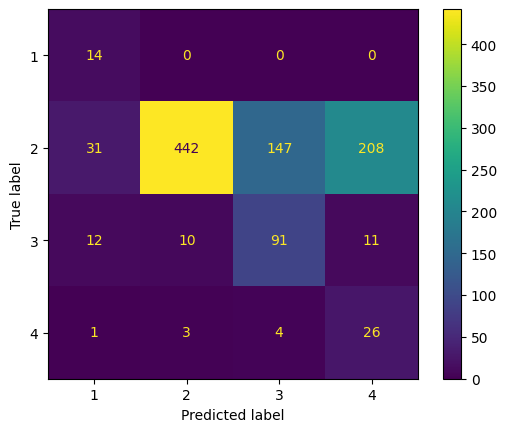

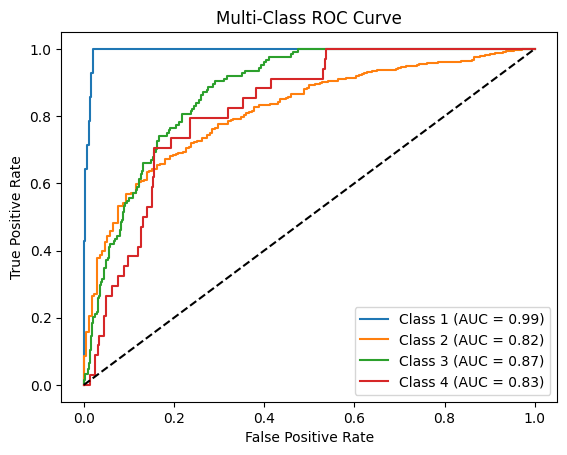

In [18]:
evaluate(y_pred_original, y_validate, X_validate, model)


Accuracy: 0.602
F1 Score: 0.6872618917671379
Classification Report:
               precision    recall  f1-score   support

           1       0.12      1.00      0.22         6
           2       0.97      0.58      0.73       857
           3       0.38      0.71      0.49       119
           4       0.05      0.61      0.09        18

    accuracy                           0.60      1000
   macro avg       0.38      0.73      0.39      1000
weighted avg       0.88      0.60      0.69      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 30 501 135 191]
 [ 11  11  84  13]
 [  1   4   2  11]]
Accuracy1 (Exact match): 0.602
Accuracy2 (One-off accuracy): 0.793


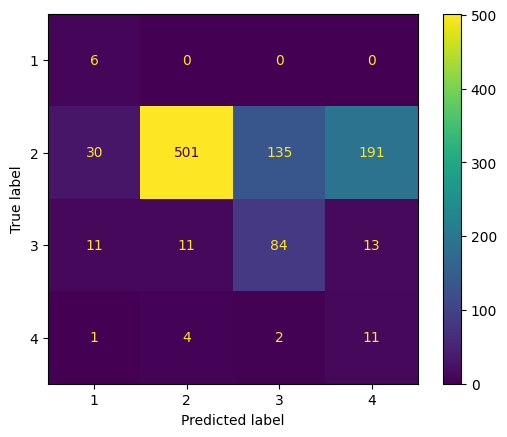

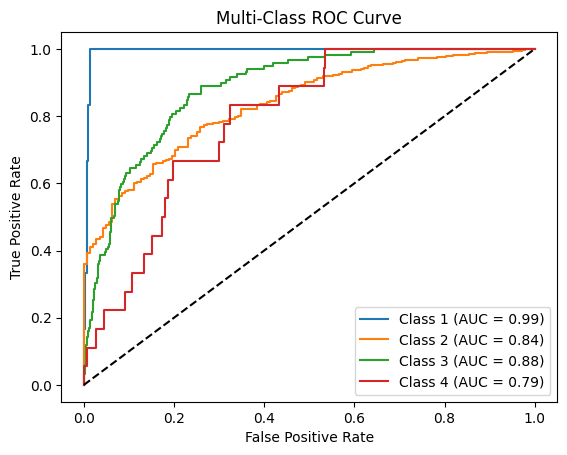

In [19]:
y_pred = model.predict(X_test)
y_pred_original = y_pred + np.min(y_train)

evaluate(y_pred_original, y_test, X_test, model)


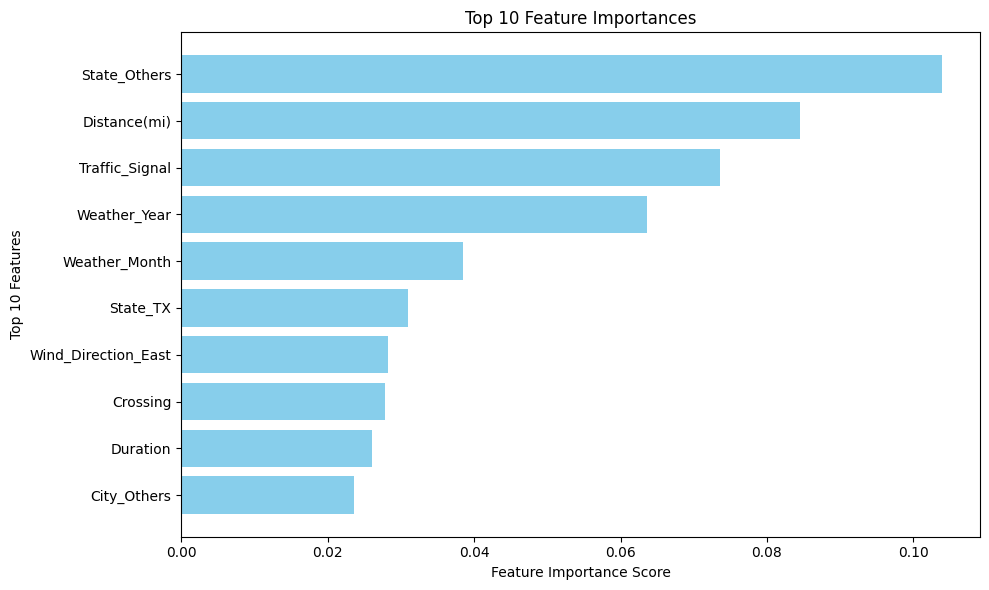

In [20]:
plot_top_feature_importances(model, X_train, selector=None, top_n=10)

# Backward Selection

In [21]:
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
import numpy as np

def xgb_feature_selection_evaluate(n_features, X_train, y_train, X_validate, y_validate, X_test, y_test):
    """
    Performs feature selection using RFE with XGBoost, evaluates performance, and plots top features.

    Parameters:
    - n_features: number of top features to select
    - X_train, y_train: training data
    - X_validate, y_validate: validation data
    - X_test, y_test: test data

    Returns:
    - selector: RFE selector
    """

    # Adjust labels to start from 0 (for XGBoost)
    label_offset = np.min(y_train)
    y_train_adjusted = y_train - label_offset

    # Initialize XGBoost model
    model = XGBClassifier(random_state=42, eval_metric='mlogloss')

    # RFE for feature selection
    selector = RFE(model, n_features_to_select=n_features, step=1)
    selector.fit(X_train, y_train_adjusted)

    selected_features = X_train.columns[selector.support_]
    print("Selected features:", selected_features.tolist())

    # Transform datasets
    X_train_selected = selector.transform(X_train)
    X_validate_selected = selector.transform(X_validate)
    X_test_selected = selector.transform(X_test)

    # Train final model
    model.fit(X_train_selected, y_train_adjusted)

    # Predict and restore label offset
    y_pred_val = model.predict(X_validate_selected) + label_offset
    print("\nEvaluate (Validation Set):")
    evaluate(y_pred_val, y_validate, X_validate_selected, model)

    y_pred_test = model.predict(X_test_selected) + label_offset
    print("\nEvaluate (Test Set):")
    evaluate(y_pred_test, y_test, X_test_selected, model)

    # Plot feature importance
    plot_top_feature_importances(model, X_train, selector=selector, top_n=n_features)

    return selector


Selected features: ['Distance(mi)', 'Crossing', 'Stop', 'Traffic_Signal', 'Duration', 'Region', 'State_Others', 'State_TX', 'City_Charlotte', 'City_Los Angeles', 'City_Others', 'Weather_Year', 'Weather_Month', 'Weather_Day_of_Week_Saturday', 'Weather_Day_of_Week_Sunday']

Evaluate (Validation Set):
Accuracy: 0.601
F1 Score: 0.6685281366783585
Classification Report:
               precision    recall  f1-score   support

           1       0.24      1.00      0.39        14
           2       0.97      0.57      0.72       828
           3       0.38      0.73      0.50       124
           4       0.11      0.68      0.19        34

    accuracy                           0.60      1000
   macro avg       0.42      0.75      0.45      1000
weighted avg       0.85      0.60      0.67      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 31 473 145 179]
 [ 12  10  91  11]
 [  1   6   4  23]]
Accuracy1 (Exact match): 0.601
Accuracy2 (One-off accuracy): 0.802


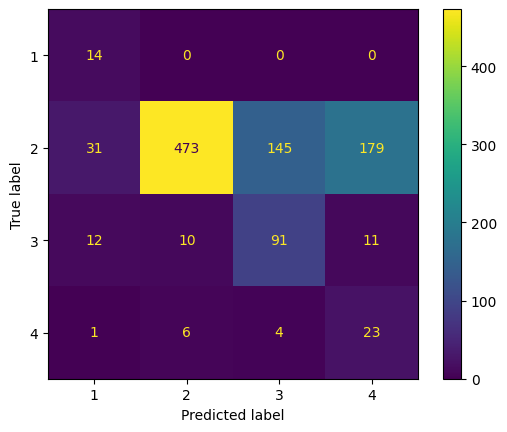

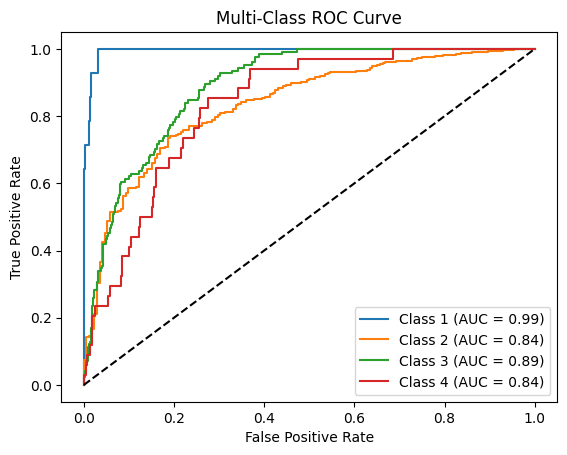


Evaluate (Test Set):
Accuracy: 0.586
F1 Score: 0.6727275453724235
Classification Report:
               precision    recall  f1-score   support

           1       0.12      1.00      0.22         6
           2       0.97      0.56      0.71       857
           3       0.38      0.73      0.50       119
           4       0.05      0.61      0.09        18

    accuracy                           0.59      1000
   macro avg       0.38      0.73      0.38      1000
weighted avg       0.88      0.59      0.67      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 30 482 142 203]
 [ 11  10  87  11]
 [  1   4   2  11]]
Accuracy1 (Exact match): 0.586
Accuracy2 (One-off accuracy): 0.781


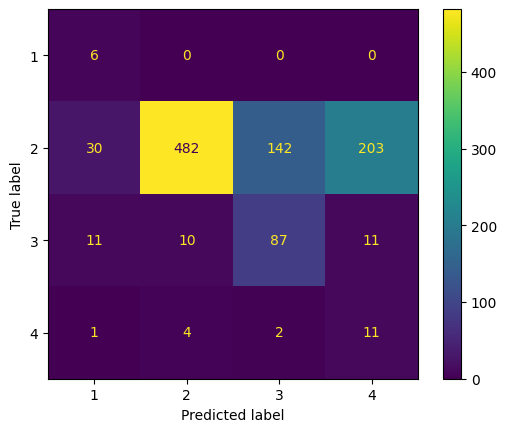

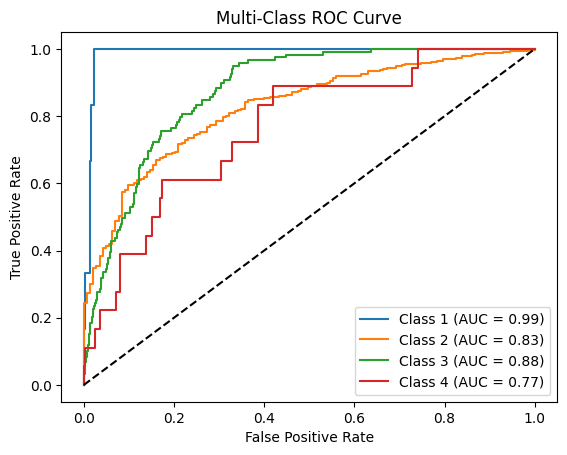

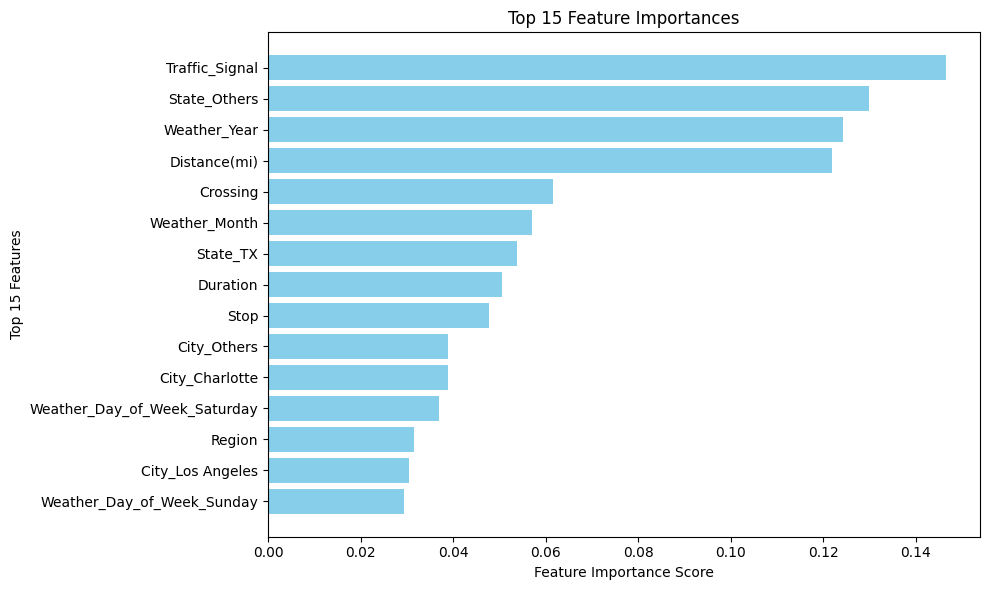

In [22]:
selector = xgb_feature_selection_evaluate(
    n_features=15,
    X_train=X_train,
    y_train=y_train,
    X_validate=X_validate,
    y_validate=y_validate,
    X_test=X_test,
    y_test=y_test
)


Selected features: ['End_Time', 'Distance(mi)', 'Crossing', 'Junction', 'Stop', 'Traffic_Signal', 'Duration', 'Region', 'State_CA', 'State_Others', 'State_TX', 'City_Charlotte', 'City_Los Angeles', 'City_Others', 'Weather_Condition_Fog / Low Visibility', 'Weather_Year', 'Weather_Month', 'Wind_Direction_WSW', 'Weather_Day_of_Week_Saturday', 'Weather_Day_of_Week_Sunday']

Evaluate (Validation Set):
Accuracy: 0.609
F1 Score: 0.6735845366977281
Classification Report:
               precision    recall  f1-score   support

           1       0.26      1.00      0.41        14
           2       0.97      0.57      0.72       828
           3       0.39      0.74      0.51       124
           4       0.13      0.82      0.22        34

    accuracy                           0.61      1000
   macro avg       0.44      0.78      0.47      1000
weighted avg       0.86      0.61      0.67      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 28 475 143 182]
 [ 12  11  92   9]
 [  0   3   3  28]]


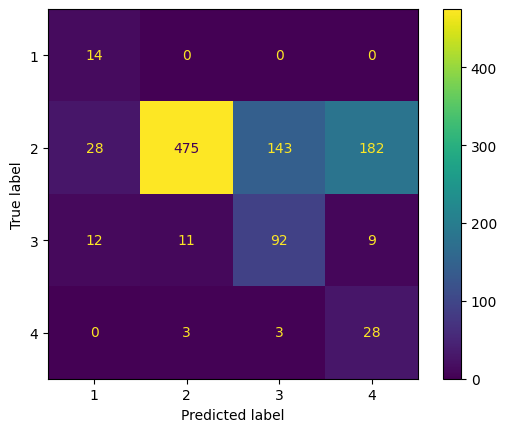

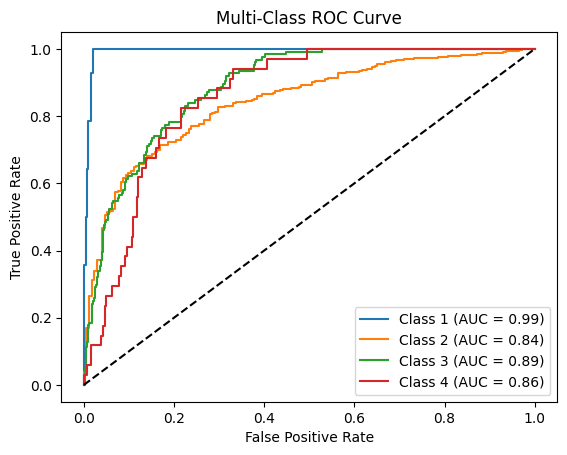


Evaluate (Test Set):
Accuracy: 0.591
F1 Score: 0.6770973974227144
Classification Report:
               precision    recall  f1-score   support

           1       0.10      0.83      0.19         6
           2       0.97      0.57      0.72       857
           3       0.38      0.75      0.50       119
           4       0.05      0.61      0.09        18

    accuracy                           0.59      1000
   macro avg       0.38      0.69      0.37      1000
weighted avg       0.88      0.59      0.68      1000

Confusion Matrix:
 [[  5   0   0   1]
 [ 34 486 143 194]
 [  8   9  89  13]
 [  1   4   2  11]]
Accuracy1 (Exact match): 0.591
Accuracy2 (One-off accuracy): 0.792


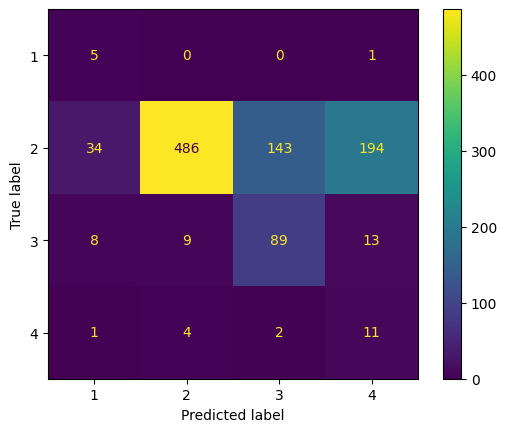

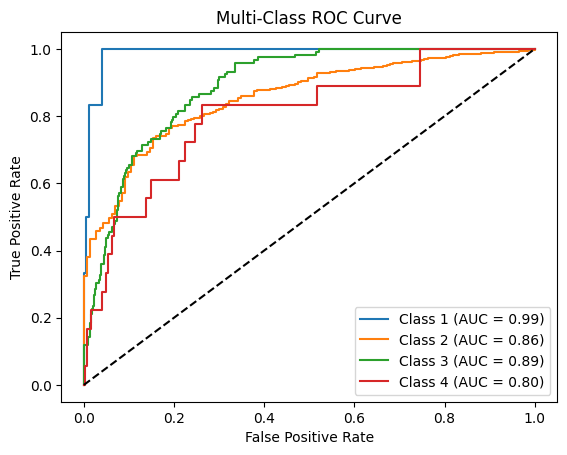

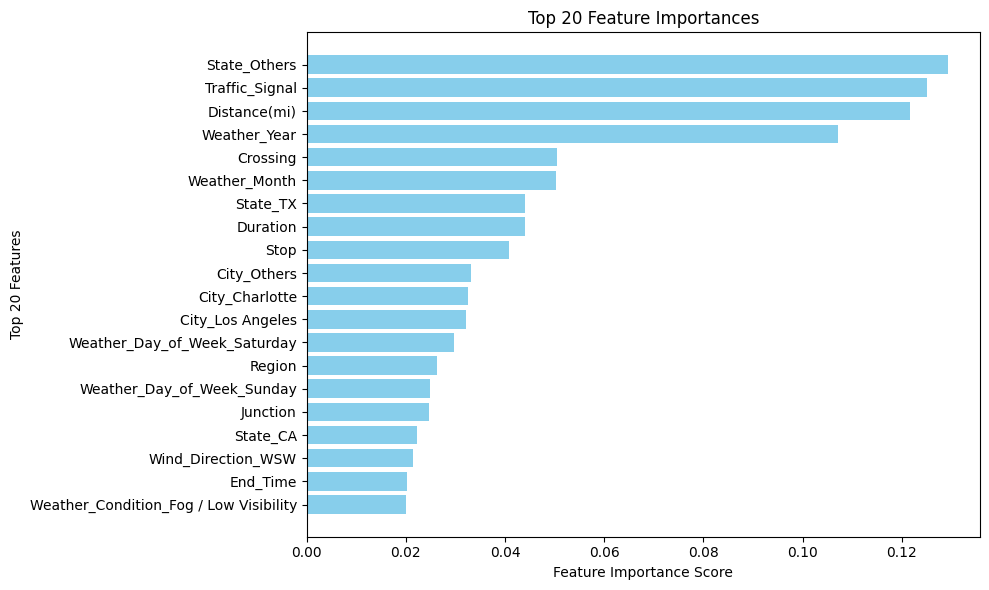

In [23]:
selector = xgb_feature_selection_evaluate(
    n_features=20,
    X_train=X_train,
    y_train=y_train,
    X_validate=X_validate,
    y_validate=y_validate,
    X_test=X_test,
    y_test=y_test
)

Selected features: ['End_Time', 'Distance(mi)', 'Pressure(in)', 'Crossing', 'Junction', 'Stop', 'Traffic_Signal', 'Duration', 'Region', 'State_CA', 'State_Others', 'State_TX', 'City_Charlotte', 'City_Los Angeles', 'City_Others', 'Weather_Condition_Fog / Low Visibility', 'Weather_Year', 'Weather_Month', 'Wind_Direction_East', 'Wind_Direction_N', 'Wind_Direction_SSE', 'Wind_Direction_SSW', 'Wind_Direction_WSW', 'Weather_Day_of_Week_Saturday', 'Weather_Day_of_Week_Sunday']

Evaluate (Validation Set):
Accuracy: 0.594
F1 Score: 0.6617049269327165
Classification Report:
               precision    recall  f1-score   support

           1       0.23      1.00      0.37        14
           2       0.96      0.56      0.71       828
           3       0.38      0.73      0.49       124
           4       0.11      0.71      0.19        34

    accuracy                           0.59      1000
   macro avg       0.42      0.75      0.44      1000
weighted avg       0.85      0.59      0.66     

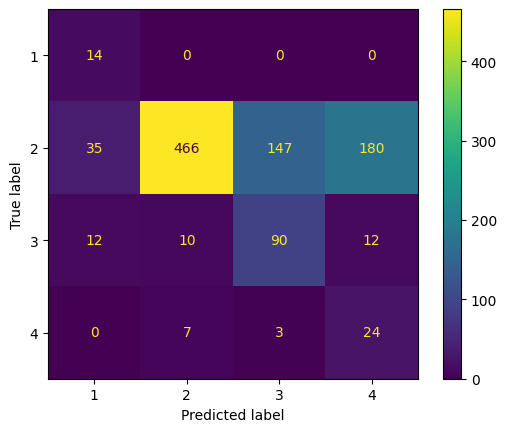

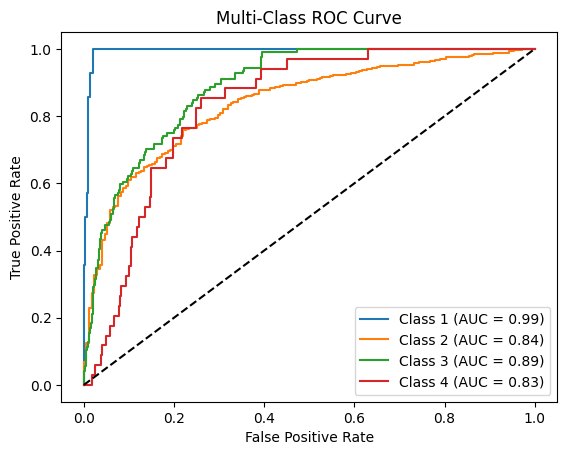


Evaluate (Test Set):
Accuracy: 0.599
F1 Score: 0.6832216579222937
Classification Report:
               precision    recall  f1-score   support

           1       0.13      1.00      0.24         6
           2       0.98      0.57      0.72       857
           3       0.38      0.76      0.51       119
           4       0.05      0.61      0.09        18

    accuracy                           0.60      1000
   macro avg       0.39      0.74      0.39      1000
weighted avg       0.88      0.60      0.68      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 29 492 143 193]
 [  9   8  90  12]
 [  1   4   2  11]]
Accuracy1 (Exact match): 0.599
Accuracy2 (One-off accuracy): 0.793


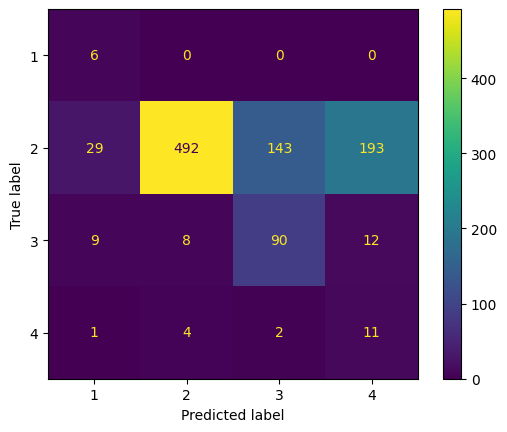

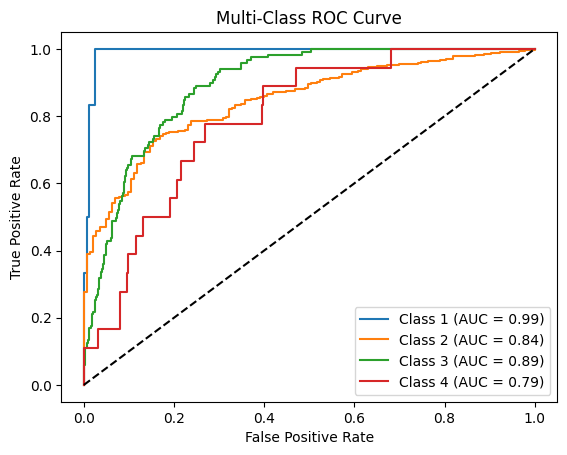

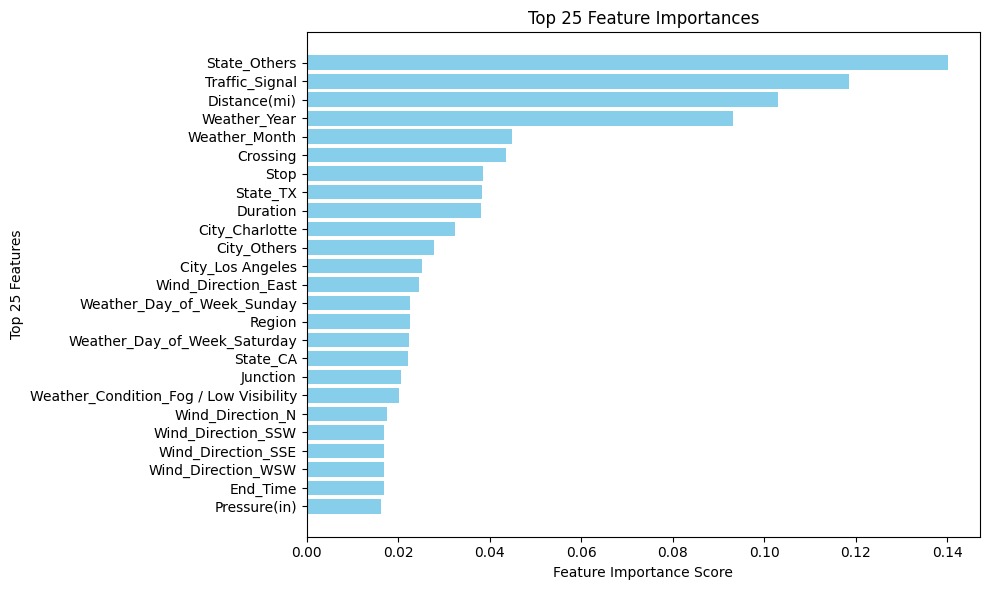

In [24]:
selector = xgb_feature_selection_evaluate(
    n_features=25,
    X_train=X_train,
    y_train=y_train,
    X_validate=X_validate,
    y_validate=y_validate,
    X_test=X_test,
    y_test=y_test
)

# Hyperparameter Tuning

In [25]:
from sklearn.metrics import make_scorer

def tune_xgb_with_rfe(X_train, y_train, X_validate, y_validate, X_test, y_test, param_grid, n_features=20):
    """
    Perform Recursive Feature Elimination (RFE) with XGBoost, followed by hyperparameter tuning 
    using GridSearchCV with F1 scoring and 5-fold cross-validation.

    Parameters:
    - X_train, y_train: Training data and labels
    - X_validate, y_validate: Validation data and labels
    - X_test, y_test: Test data and labels
    - n_features: Number of features to select using RFE
    - param_grid: Parameter grid for hyperparameter tuning

    Returns:
    - best_model: The best XGBoost model after tuning
    """
    
    # Step 1: Perform Recursive Feature Elimination (RFE)
    y_train_adjusted = y_train - np.min(y_train)  # Adjust target values if necessary
    selector = RFE(XGBClassifier(random_state=42, eval_metric="mlogloss"), n_features_to_select=n_features, step=1)
    selector.fit(X_train, y_train_adjusted)

    # Select only important features
    X_train_selected = selector.transform(X_train)
    X_validate_selected = selector.transform(X_validate)
    X_test_selected = selector.transform(X_test)

    # Step 2: Define a custom scorer for F1 (weighted)
    f1_scorer = make_scorer(f1_score, average='weighted')

    # Step 3: Initialize GridSearchCV with cross-validation and F1 scorer
    grid_search = GridSearchCV(
        estimator=XGBClassifier(random_state=42, eval_metric='mlogloss'),
        param_grid=param_grid,
        cv=5,  # Cross-validation folds
        scoring=f1_scorer,  # Use F1 weighted scorer
        n_jobs=-1,  # Use all available CPUs
        verbose=2
    )

    # Step 4: Fit the grid search to the **selected feature** training data
    grid_search.fit(X_train_selected, y_train_adjusted)

    # Step 5: Get the best model from the grid search
    best_model = grid_search.best_estimator_

    # Print the best parameters found
    print("Best parameters found: ", grid_search.best_params_)

    # Step 6: Make predictions using the best model on the validation set
    y_pred_validate = best_model.predict(X_validate_selected)
    y_pred_validate_original = y_pred_validate + np.min(y_train)
    print("\nEvaluate (Validation Set):")
    evaluate(y_pred_validate_original, y_validate, X_validate_selected, best_model)

    # Step 7: Evaluate on the test set
    y_pred_test = best_model.predict(X_test_selected)
    y_pred_test_original = y_pred_test + np.min(y_train)
    print("\nEvaluate (Test Set):")
    evaluate(y_pred_test_original, y_test, X_test_selected, best_model)

    plot_top_feature_importances(best_model, X_train, selector=selector, top_n=n_features)

    return best_model


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=1.0; total time

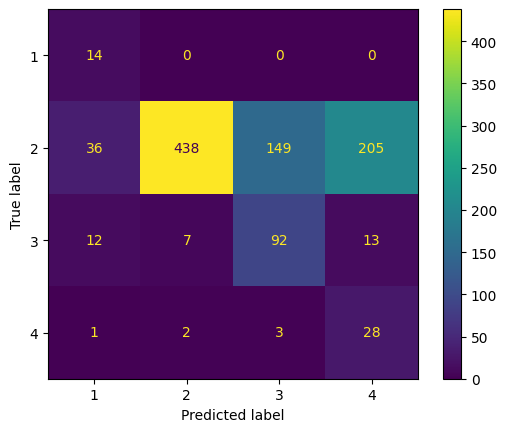

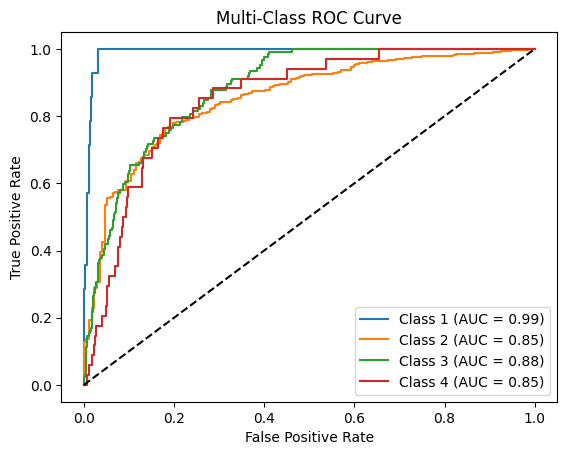


Evaluate (Test Set):
Accuracy: 0.574
F1 Score: 0.6644612034970254
Classification Report:
               precision    recall  f1-score   support

           1       0.11      1.00      0.20         6
           2       0.98      0.55      0.70       857
           3       0.37      0.71      0.49       119
           4       0.05      0.72      0.10        18

    accuracy                           0.57      1000
   macro avg       0.38      0.75      0.37      1000
weighted avg       0.89      0.57      0.66      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 35 470 140 212]
 [ 12   7  85  15]
 [  1   2   2  13]]
Accuracy1 (Exact match): 0.574
Accuracy2 (One-off accuracy): 0.773


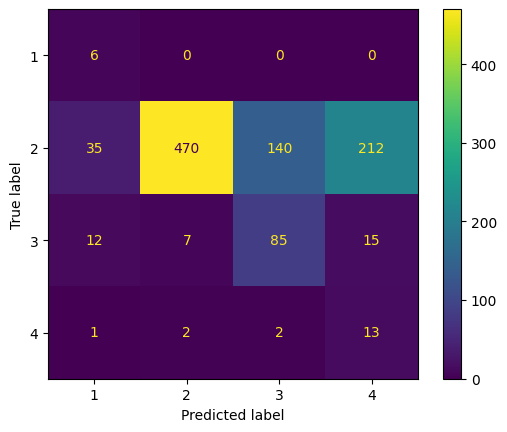

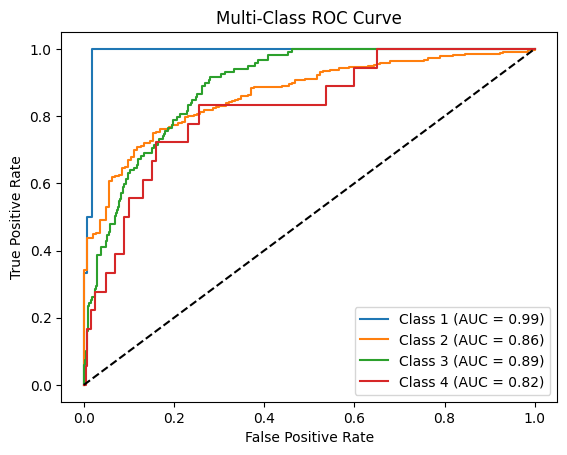

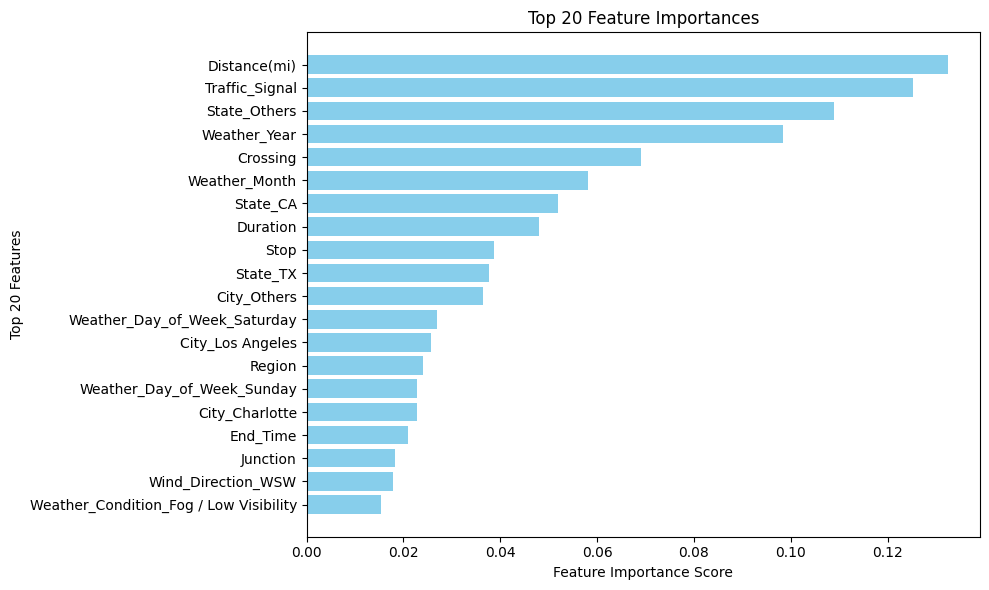

In [27]:
param_grid = {
    'n_estimators': [50, 100, 150],        # Number of trees in the model
    'max_depth': [3, 5, 10, 20],           # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.2],    # Step size for gradient descent
    'subsample': [0.8, 1.0],               # Proportion of samples used for training each tree
    'colsample_bytree': [0.8, 1.0],        # Proportion of features to be used for each tree
    'min_child_weight': [1, 2, 3],          # Minimum sum of instance weight (hessian) needed in a child
}
best_model_xgb = tune_xgb_with_rfe(
    X_train, y_train, 
    X_validate, y_validate, 
    X_test, y_test, 
    param_grid=param_grid,
    n_features=20  
)




Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 0.8}


Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=130, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=130, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=130, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=130, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=130, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=130, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=130, subsample=0.9; total

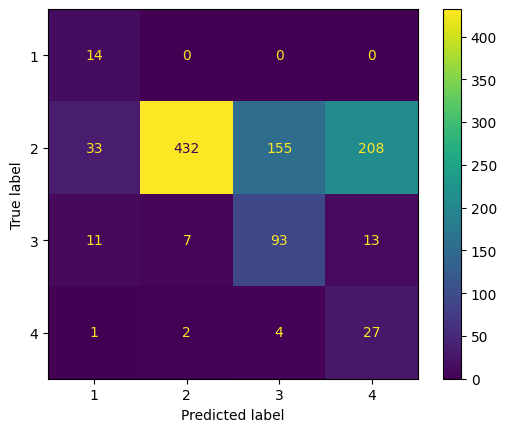

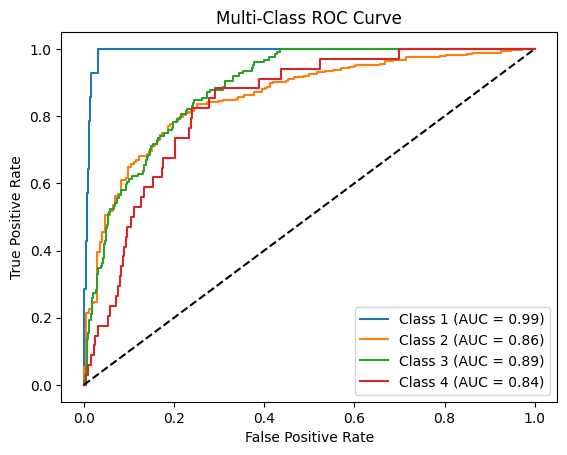


Evaluate (Test Set):
Accuracy: 0.587
F1 Score: 0.6761827794934182
Classification Report:
               precision    recall  f1-score   support

           1       0.11      1.00      0.20         6
           2       0.99      0.56      0.71       857
           3       0.39      0.74      0.51       119
           4       0.06      0.72      0.10        18

    accuracy                           0.59      1000
   macro avg       0.39      0.76      0.38      1000
weighted avg       0.89      0.59      0.68      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 34 480 137 206]
 [ 13   5  88  13]
 [  2   1   2  13]]
Accuracy1 (Exact match): 0.587
Accuracy2 (One-off accuracy): 0.778


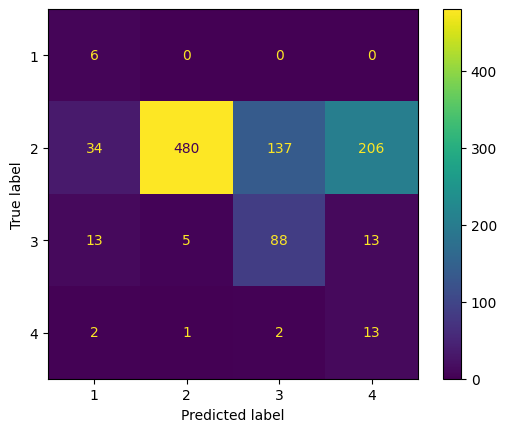

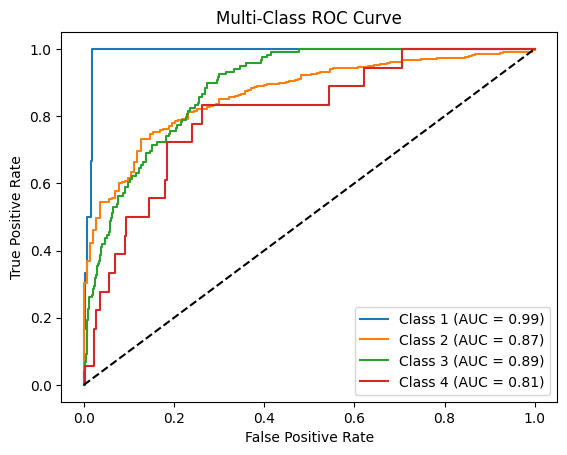

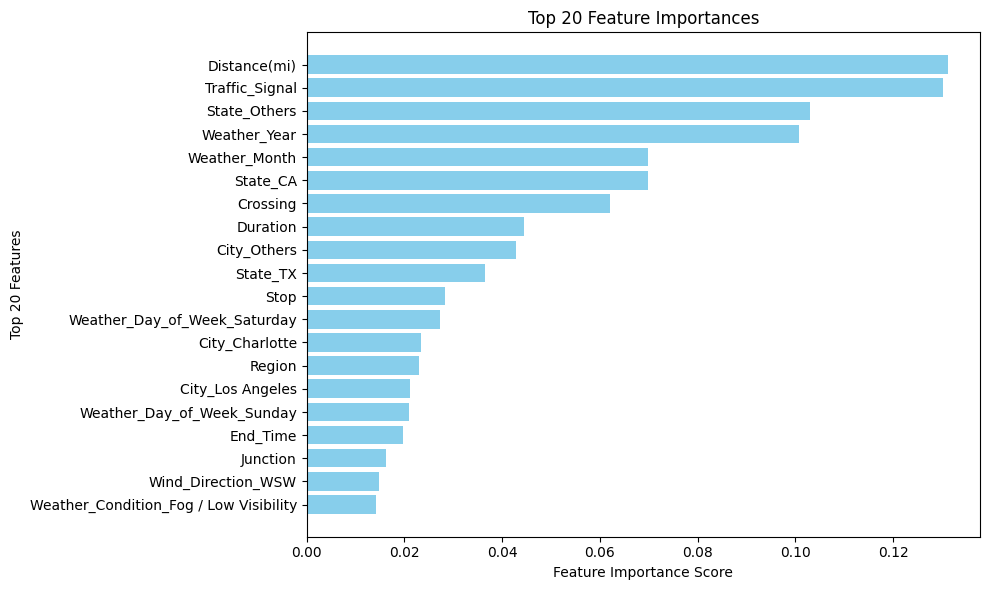

In [28]:
# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [130, 170],        # Number of trees in the model
    'max_depth': [4, 6],           # Maximum depth of each tree
    'learning_rate': [0.05, 0.15],    # Step size for gradient descent
    'subsample': [0.7, 0.9],               # Proportion of samples used for training each tree
    'colsample_bytree': [0.7, 0.9],        # Proportion of features to be used for each tree
    'min_child_weight': [1],          # Minimum sum of instance weight (hessian) needed in a child
}
best_model_xgb = tune_xgb_with_rfe(
    X_train, y_train, 
    X_validate, y_validate, 
    X_test, y_test, 
    param_grid=param_grid,
    n_features=20 
)

Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.15, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 170, 'subsample': 0.9}


# Hyperparameter Tuning with BayesSearch

In [65]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [69]:
def tune_evaluate(X_train, y_train, X_validate, y_validate, X_test, y_test, param_grid, scorer, n_features=20):
    # Step 1: Perform Recursive Feature Elimination (RFE)
    y_train_adjusted = y_train - np.min(y_train)  # Adjust target values if necessary
    selector = RFE(XGBClassifier(random_state=42, eval_metric="mlogloss"), n_features_to_select=n_features, step=1)
    selector.fit(X_train, y_train_adjusted)

    # Select only important features
    X_train_selected = selector.transform(X_train)
    X_validate_selected = selector.transform(X_validate)
    X_test_selected = selector.transform(X_test)
    
    
    opt = BayesSearchCV(estimator=XGBClassifier(random_state=42, eval_metric="mlogloss"),                                    
                    search_spaces=param_grid,                      
                    scoring=scorer,                           
                    cv=5,                                           
                    n_iter=60,
                    n_points=3,
                    n_jobs=-1,
                    iid=False,
                    return_train_score=False,                         
                    refit=True,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},        
                    random_state=42)
    
    opt.fit(X_train_selected, y_train_adjusted)
    best_model = opt.best_estimator_
    print("Best optimzer score: ", opt.best_score_)
    print("Best parameters: ", opt.best_params_)

    # Step 6: Make predictions using the best model on the validation set
    y_pred_validate = best_model.predict(X_validate_selected)
    y_pred_validate_original = y_pred_validate + np.min(y_train)
    print("\nEvaluate (Validation Set):")
    evaluate(y_pred_validate_original, y_validate, X_validate_selected, best_model)

    # Step 7: Evaluate on the test set
    y_pred_test = best_model.predict(X_test_selected)
    y_pred_test_original = y_pred_test + np.min(y_train)
    print("\nEvaluate (Test Set):")
    evaluate(y_pred_test_original, y_test, X_test_selected, best_model)

    plot_top_feature_importances(best_model, X_train, selector=selector, top_n=n_features)

    return best_model, opt.best_params_

In [70]:
param_grid = {
    'n_estimators': Integer(30, 5000),        # Number of trees in the model
    'max_depth': Integer(0, 256),           # Maximum depth of each tree
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),    # Step size for gradient descent
    'subsample': Real(0.01, 1.0, 'uniform'),               # Proportion of samples used for training each tree
    'colsample_bytree': Real(0.01, 1.0, 'uniform'),        # Proportion of features to be used for each tree
    'min_child_weight': Integer(1, 20),          # Minimum sum of instance weight (hessian) needed in a child
}

/Users/winlaeyee/Downloads/traffic_accident_severity_prediction/venv/lib/python3.13/site-packages/skopt/searchcv.py:338: UserWarning: The `iid` parameter has been deprecated and will be ignored.
  warnings.warn(
/Users/winlaeyee/Downloads/traffic_accident_severity_prediction/venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best optimzer score:  0.7464790675964202
Best parameters:  OrderedDict({'colsample_bytree': 0.6785774214048165, 'learning_rate': 0.016329293669645882, 'max_depth': 111, 'min_child_weight': 1, 'n_estimators': 756, 'subsample': 0.9053286288830233})

Evaluate (Validation Set):
Accuracy: 0.586
F1 Score: 0.6548640813950902
Classification Report:
               precision    recall  f1-score   support

           1       0.26      1.00      0.41        14
           2       0.97      0.55      0.70       828
           3       0.37      0.73      0.49       124
           4       0.11      0.74      0.19        34

    accuracy                           0.59      1000
   macro avg       0.43      0.75      0.45      1000
weighted avg       0.85      0.59      0.65      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 28 457 152 191]
 [ 11  10  90  13]
 [  1   5   3  25]]
Accuracy1 (Exact match): 0.586
Accuracy2 (One-off accuracy): 0.792


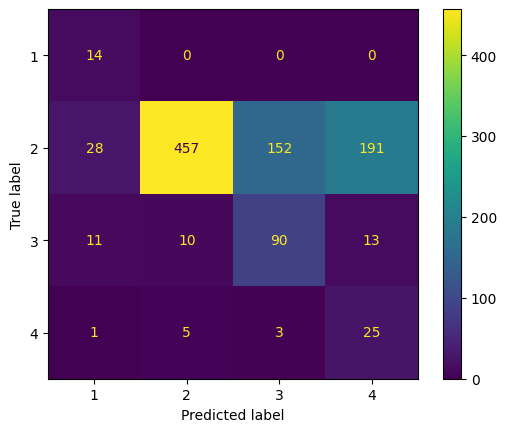

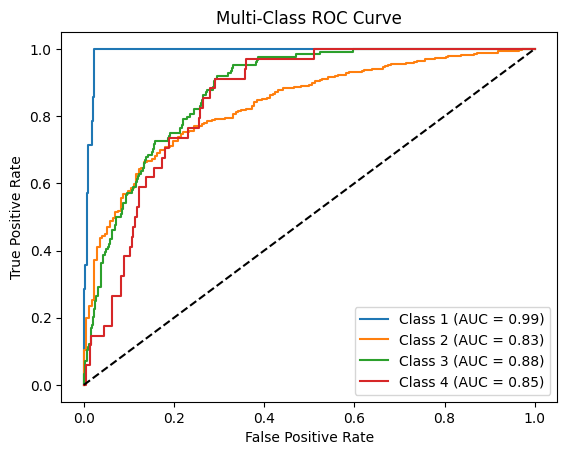


Evaluate (Test Set):
Accuracy: 0.583
F1 Score: 0.6684492411803679
Classification Report:
               precision    recall  f1-score   support

           1       0.13      1.00      0.23         6
           2       0.98      0.55      0.71       857
           3       0.38      0.76      0.51       119
           4       0.06      0.72      0.10        18

    accuracy                           0.58      1000
   macro avg       0.39      0.76      0.39      1000
weighted avg       0.89      0.58      0.67      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 31 473 148 205]
 [  8   8  91  12]
 [  1   2   2  13]]
Accuracy1 (Exact match): 0.583
Accuracy2 (One-off accuracy): 0.784


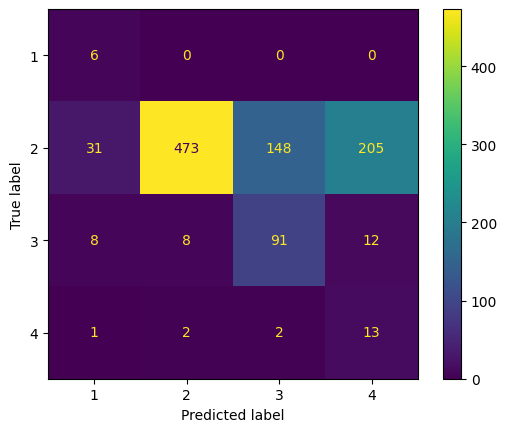

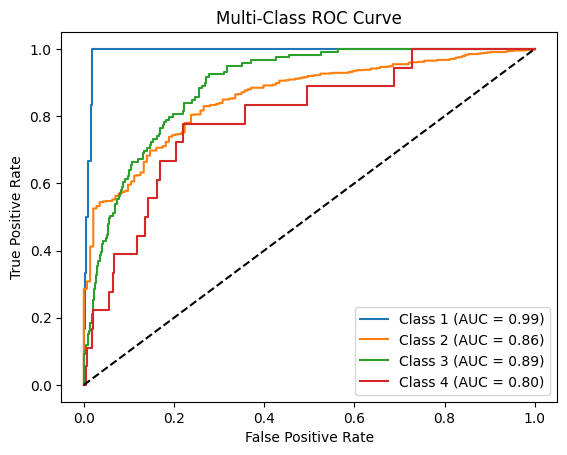

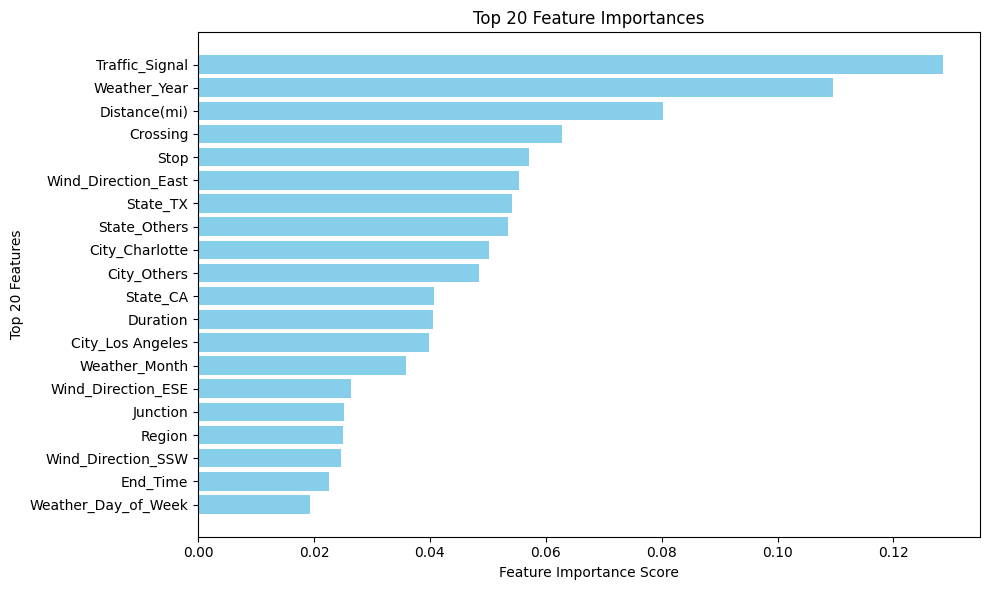

In [71]:
scorer = make_scorer(f1_score, average="weighted", greater_is_better=True)
best_model_mse1, best_params_mse1 = tune_evaluate(
    X_train, y_train, 
    X_validate, y_validate, 
    X_test, y_test, 
    param_grid=param_grid,
    scorer=scorer,
    n_features=20
)


/Users/winlaeyee/Downloads/traffic_accident_severity_prediction/venv/lib/python3.13/site-packages/skopt/searchcv.py:338: UserWarning: The `iid` parameter has been deprecated and will be ignored.
  warnings.warn(


Best optimzer score:  -0.717625
Best parameters:  OrderedDict({'colsample_bytree': 0.7459425638741971, 'learning_rate': 0.038018954998054605, 'max_depth': 203, 'min_child_weight': 1, 'n_estimators': 51, 'subsample': 0.7885013250216508})

Evaluate (Validation Set):
Accuracy: 0.564
F1 Score: 0.6347714535683039
Classification Report:
               precision    recall  f1-score   support

           1       0.24      1.00      0.39        14
           2       0.98      0.52      0.68       828
           3       0.37      0.75      0.49       124
           4       0.11      0.76      0.19        34

    accuracy                           0.56      1000
   macro avg       0.42      0.76      0.44      1000
weighted avg       0.86      0.56      0.63      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 31 431 158 208]
 [ 12   7  93  12]
 [  1   4   3  26]]
Accuracy1 (Exact match): 0.564
Accuracy2 (One-off accuracy): 0.775


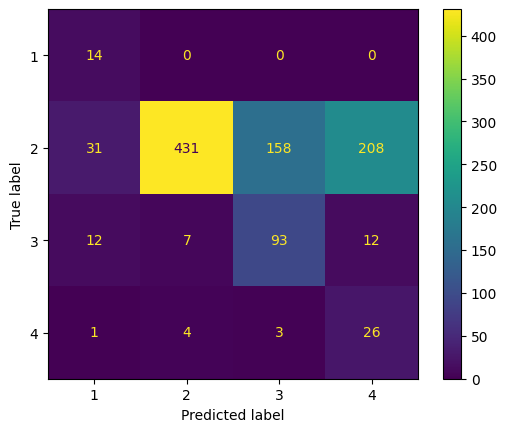

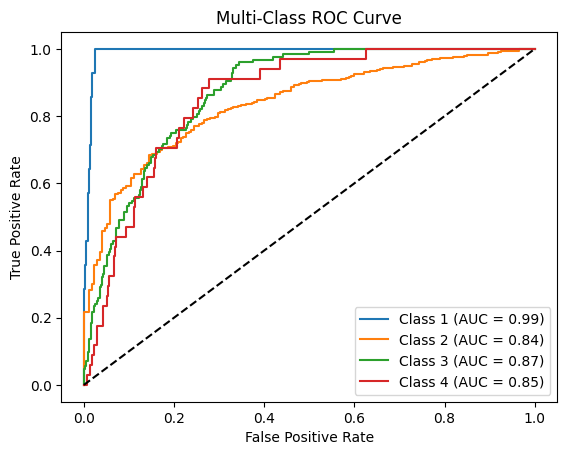


Evaluate (Test Set):
Accuracy: 0.561
F1 Score: 0.6489127788565687
Classification Report:
               precision    recall  f1-score   support

           1       0.12      1.00      0.21         6
           2       0.98      0.53      0.69       857
           3       0.36      0.77      0.49       119
           4       0.05      0.67      0.09        18

    accuracy                           0.56      1000
   macro avg       0.38      0.74      0.37      1000
weighted avg       0.89      0.56      0.65      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 34 451 161 211]
 [ 10   5  92  12]
 [  1   3   2  12]]
Accuracy1 (Exact match): 0.561
Accuracy2 (One-off accuracy): 0.775


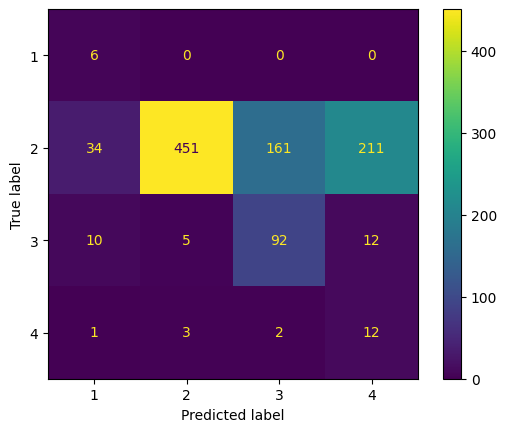

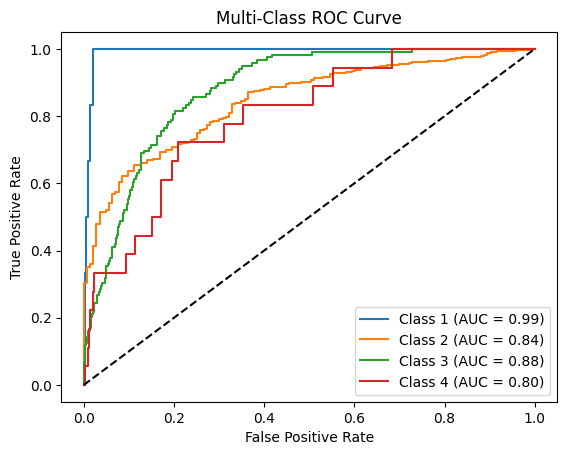

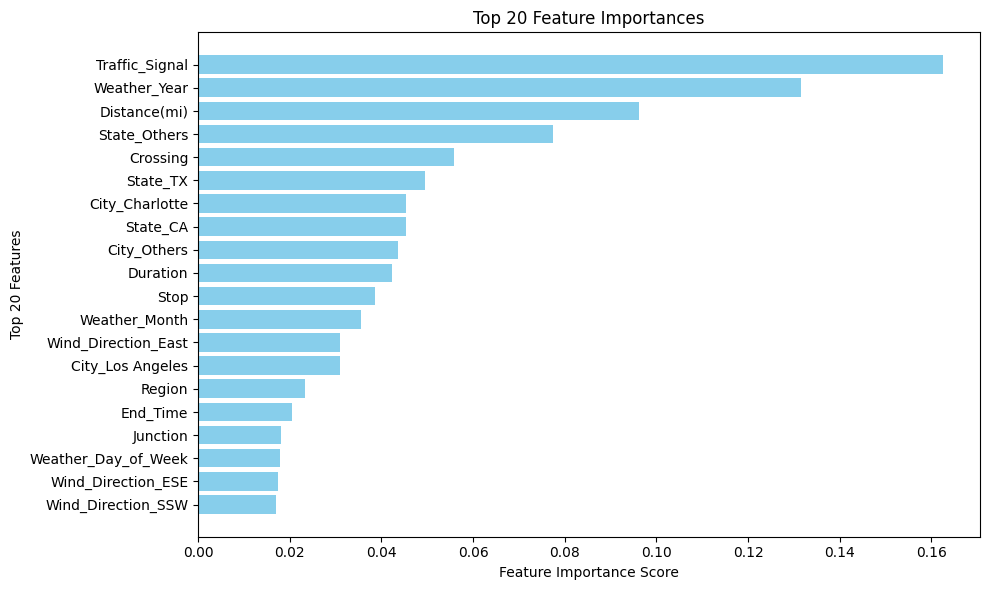

In [72]:

scorer = make_scorer(mean_squared_error, greater_is_better=False)
best_model_mse1, best_params_mse1 = tune_evaluate(
    X_train, y_train, 
    X_validate, y_validate, 
    X_test, y_test, 
    param_grid=param_grid,
    scorer=scorer,
    n_features=20
)

/Users/winlaeyee/Downloads/traffic_accident_severity_prediction/venv/lib/python3.13/site-packages/skopt/searchcv.py:338: UserWarning: The `iid` parameter has been deprecated and will be ignored.
  warnings.warn(


Best optimzer score:  -0.39862499999999995
Best parameters:  OrderedDict({'colsample_bytree': 0.6112552987157325, 'learning_rate': 0.09186505581500987, 'max_depth': 240, 'min_child_weight': 1, 'n_estimators': 30, 'subsample': 0.8394609995239084})

Evaluate (Validation Set):
Accuracy: 0.572
F1 Score: 0.6415014642615029
Classification Report:
               precision    recall  f1-score   support

           1       0.25      1.00      0.39        14
           2       0.97      0.53      0.69       828
           3       0.36      0.72      0.48       124
           4       0.11      0.79      0.20        34

    accuracy                           0.57      1000
   macro avg       0.42      0.76      0.44      1000
weighted avg       0.85      0.57      0.64      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 31 442 156 199]
 [ 12  11  89  12]
 [  0   3   4  27]]
Accuracy1 (Exact match): 0.572
Accuracy2 (One-off accuracy): 0.786


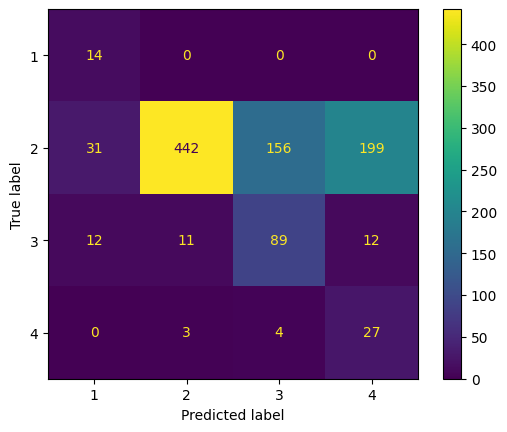

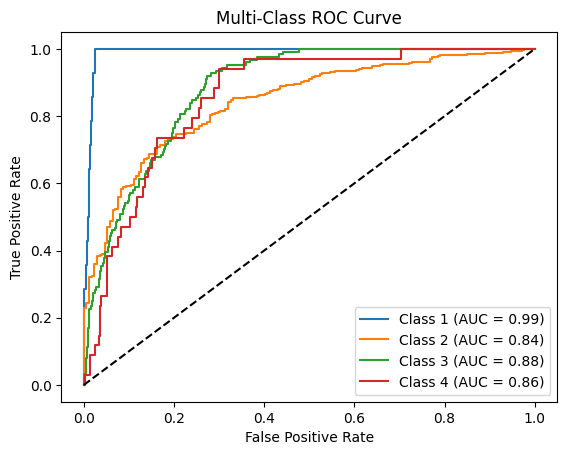


Evaluate (Test Set):
Accuracy: 0.571
F1 Score: 0.6588470226950778
Classification Report:
               precision    recall  f1-score   support

           1       0.12      1.00      0.22         6
           2       0.98      0.54      0.70       857
           3       0.36      0.74      0.48       119
           4       0.06      0.72      0.10        18

    accuracy                           0.57      1000
   macro avg       0.38      0.75      0.38      1000
weighted avg       0.89      0.57      0.66      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 33 464 154 206]
 [  8   7  88  16]
 [  1   2   2  13]]
Accuracy1 (Exact match): 0.571
Accuracy2 (One-off accuracy): 0.783


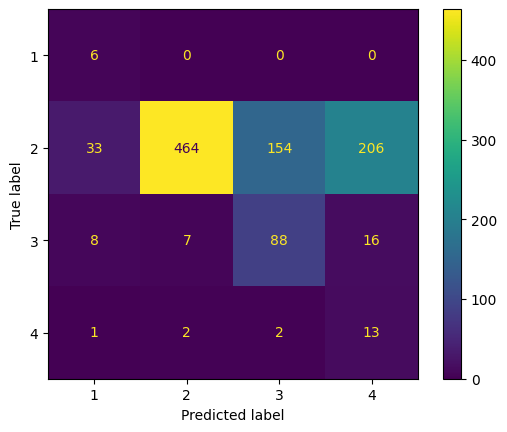

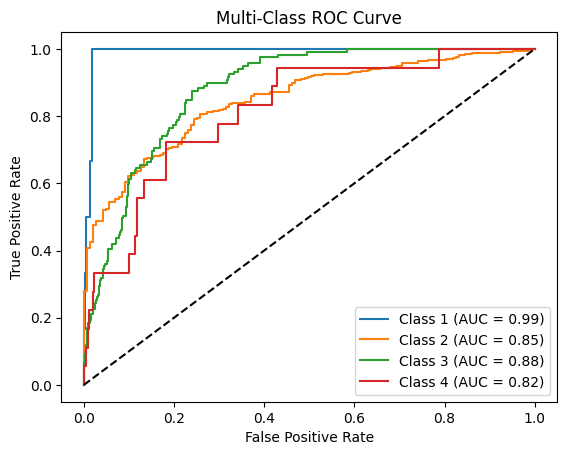

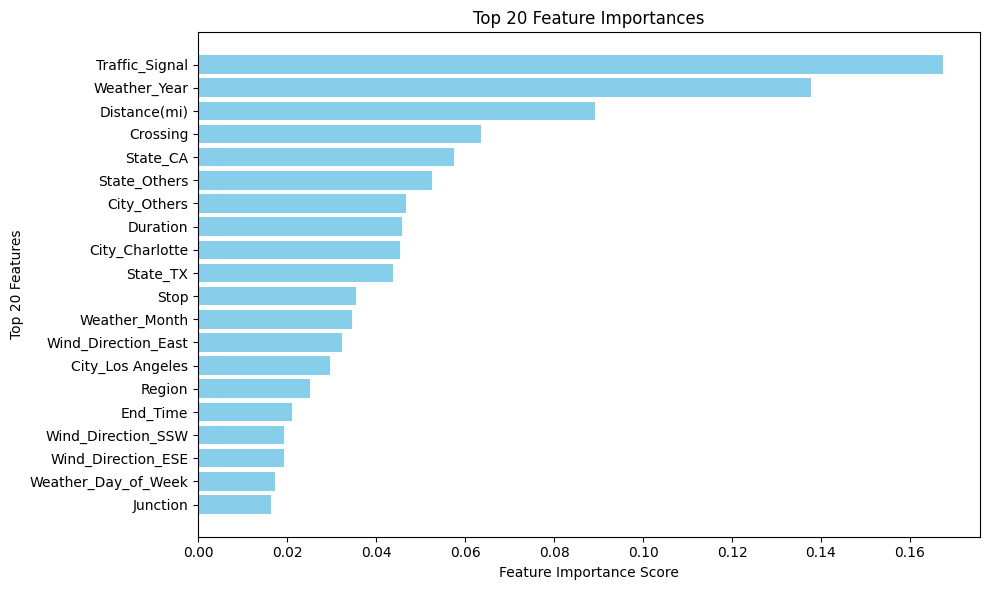

In [73]:

scorer = make_scorer(mean_absolute_error, greater_is_better=False)
best_model_mse1, best_params_mse1 = tune_evaluate(
    X_train, y_train, 
    X_validate, y_validate, 
    X_test, y_test, 
    param_grid=param_grid,
    scorer=scorer,
    n_features=20
)